In [64]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.solvers import *

In [65]:
#Defining parameters
epsilon = 0.02
gamma = 50
M = 0.7*1e-4
maxh = 0.01 
order = 1 
tau = 0.1            
T = 1

In [66]:
def phi_exact(t):
    return t*cos(np.pi*x)*cos(np.pi*y)

def phi_dt(t):
    return cos(np.pi*x)*cos(np.pi*y)

def phi_lap(t):
    return -2*np.pi**2*phi_exact(t)

def mu_exact():
    return cos(np.pi*x)*cos(np.pi*y)

def mu_lap():
    return -2*np.pi**2*mu_exact()

In [67]:
def FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):

    #Defining Bilinear form
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx + mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    A.Assemble()

    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx+gamma*(phi_old**3-phi_old)*w*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error, integral,energy

In [68]:
def IMEXScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):
    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)
    t=0
    L2_error = []
    integral = []
    energy=[]
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -gamma*(phi_exact(t)**2-1)*phi*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx

    #t=0
    while t<T:
        t+=tau

         #Defining Bilinear form
        #A = BilinearForm(fes)
        #A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -gamma*(phi_exact(t)**2-1)*phi*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx
        A.Assemble()

        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec
        #t += tau

    return gfut,gfu, L2_error, integral,energy

In [69]:
def FullyImplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T):

    #Defining Bilinear form
    A = BilinearForm(fes)
    A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -+gamma*(phi**3-phi)*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx
    A.Assemble()

    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    t=0
    while t<T:
        t+=tau
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)

        #Defining Bilinear form
        A = BilinearForm(fes)
        A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx -+gamma*(phi**3-phi)*w*dx+ mu*w*dx-epsilon*grad(phi)*grad(w)*dx- (tau*rhs1*v*dx+ phi_old*v*dx + rhs2*w*dx)
        A.Assemble()
            

        #Solving for phi with Newton iterations
        Newton(A,gfu,freedofs=gfu.space.FreeDofs(),maxit=10,maxerr=1e-11,inverse="umfpack",dampfactor=1,printing=True)

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error,integral, energy

In [70]:
#Defining mesh and Finite element space
mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
V = H1(mesh, order=1) 
fes = V*V 

#Defining trial and test functions
phi,mu = fes.TrialFunction()  #n+1
v,w = fes.TestFunction()

#Initialising phi_0 random values between -1 and 1
phi_old = GridFunction(V)
initial_values = np.zeros(V.ndof)
phi_old.vec.data = initial_values

In [71]:
def convergence_analysis(H,Tau,scheme):
    L2 = []
    for maxh in H:
        for tau in Tau:
            #Defining mesh and Finite element space
            mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
            V = H1(mesh, order=order) 
            fes = V*V 

            #Defining trial and test functions
            phi,mu = fes.TrialFunction() 
            v,w = fes.TestFunction()

            #Initialising phi_0 
            phi_old = GridFunction(V)
            initial_values = np.zeros(V.ndof)
            phi_old.vec.data = initial_values

            gfut,gfu,L2_error,integral,energy = scheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,tau,T)
            L2.append([tau, maxh, max(L2_error)])
            df = pd.DataFrame(L2, columns=["tau", "maxh", "L2_error"])
    return df, integral, energy

In [83]:
N = np.array([1,2,3,4])
H = 0.2*2.0**(-N)
Tau = H

Explicit_df, Explicit_integral, Explicit_energy = convergence_analysis(H,Tau,FullyExplicitScheme)
IMEX_df, IMEX_integral, IMEX_energy = convergence_analysis(H,Tau,IMEXScheme)
Implicit_df, Implicit_integral,Implicit_energy = convergence_analysis(H,Tau,FullyImplicitScheme)


no more timer available (lff_from_py), reusing last one


Newton iteration  0
err =  1.2018590767069477
Newton iteration  1
err =  0.01572165768768478
Newton iteration  2
err =  1.3503539903080695e-09
Newton iteration  3
err =  3.160737770054767e-16
Newton iteration  0
err =  0.3609654716654329
Newton iteration  1
err =  0.06289768177575598
Newton iteration  2
err =  4.30446627477112e-08
Newton iteration  3
err =  5.169086773637027e-16
Newton iteration  0
err =  0.4578850696320045
Newton iteration  1
err =  0.11004923093872947
Newton iteration  2
err =  1.9487529188250277e-07
Newton iteration  3
err =  7.909875819850127e-16
Newton iteration  0
err =  0.5062494764871671
Newton iteration  1
err =  0.15712417022391706
Newton iteration  2
err =  5.162875517783853e-07
Newton iteration  3
err =  9.697862135032059e-16
Newton iteration  0
err =  0.5069557133122391
Newton iteration  1
err =  0.20407177773169746
Newton iteration  2
err =  1.0558563343439997e-06
Newton iteration  3
err =  1.5628836342616647e-15
Newton iteration  0
err =  0.4460030600926

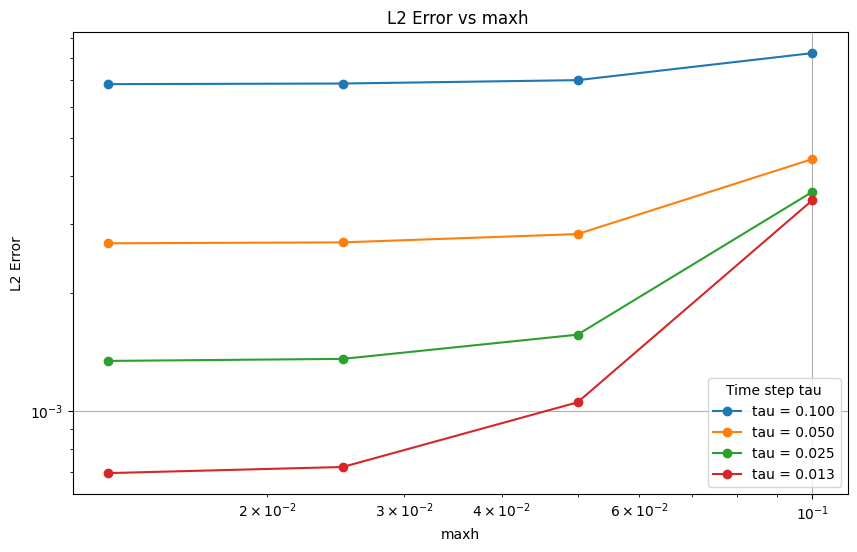

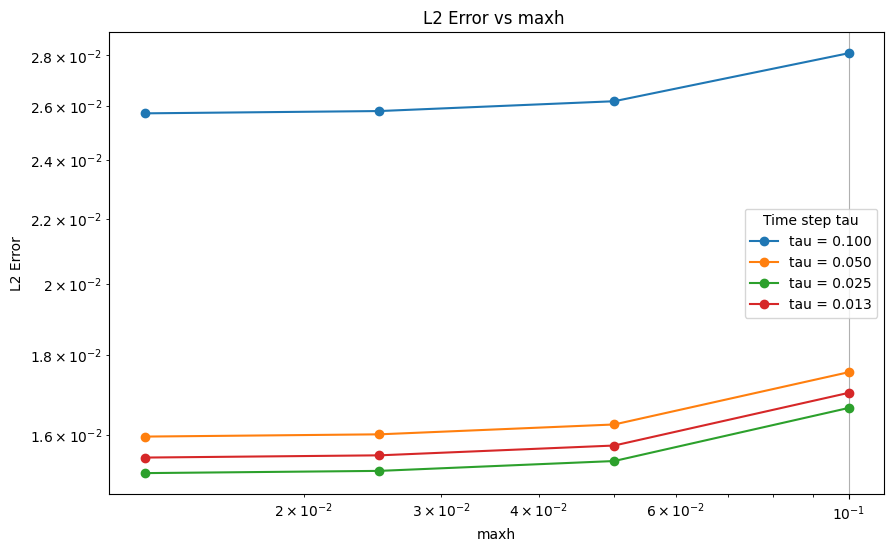

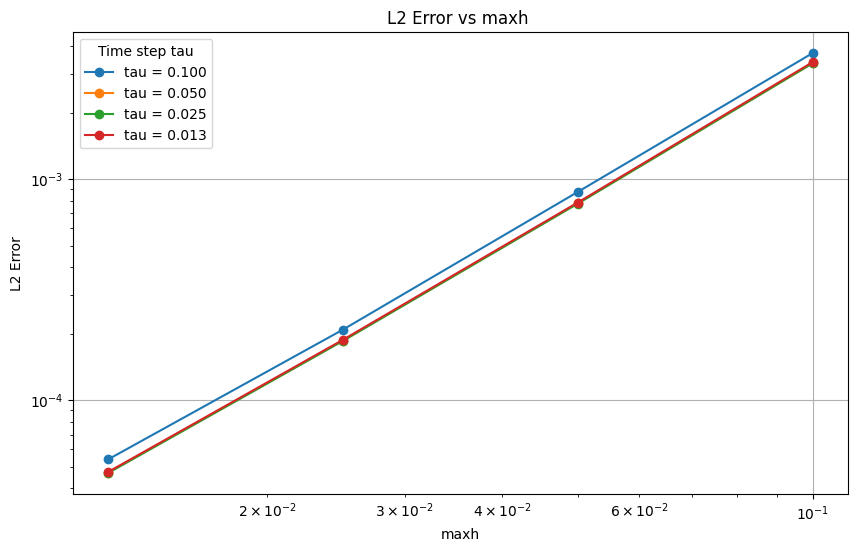

In [73]:
for df in [Explicit_df,IMEX_df,Implicit_df]:
    plt.figure(figsize=(10, 6))
    for tau in df['tau'].unique():
        df_tau = df[df['tau'] == tau]
        plt.loglog(df_tau['maxh'], df_tau['L2_error'], marker='o', label=f'tau = {tau:.3f}')
    plt.xlabel('maxh')
    plt.ylabel('L2 Error')
    plt.title('L2 Error vs maxh ')
    plt.legend(title="Time step tau")
    plt.grid(True)
    plt.show()


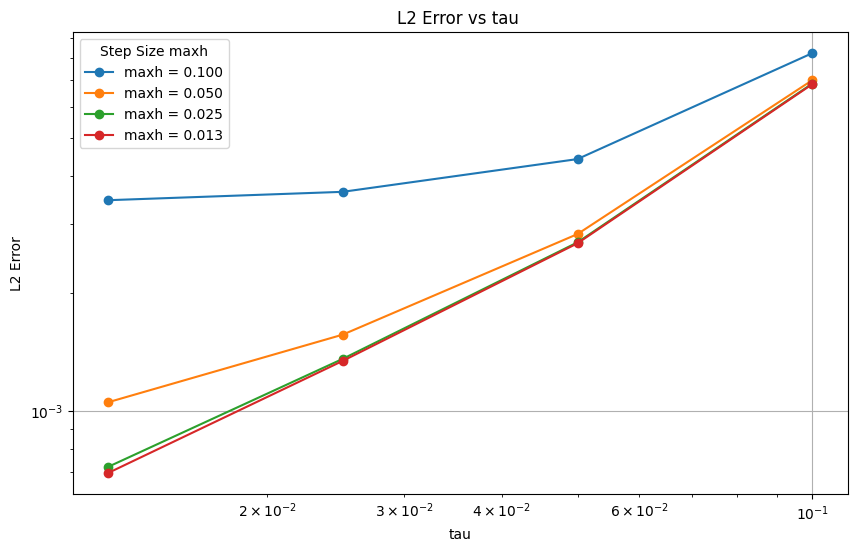

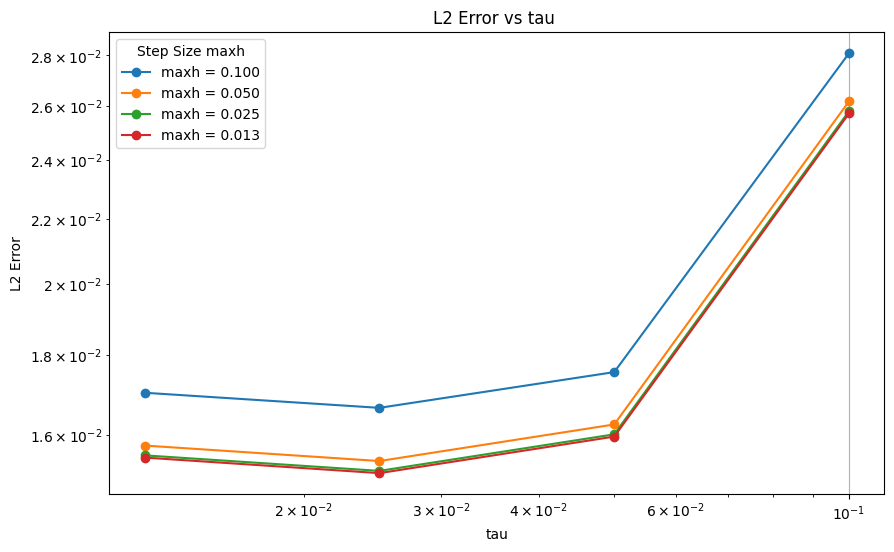

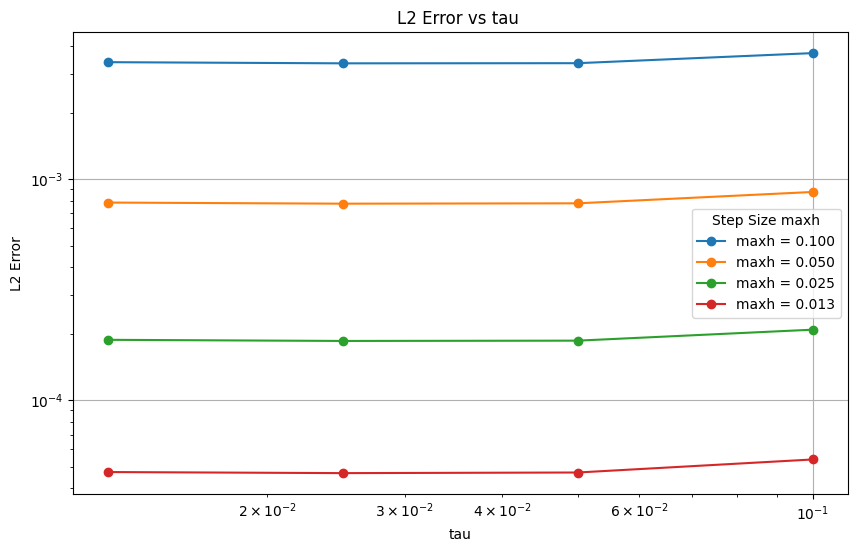

In [74]:
for df in [Explicit_df,IMEX_df,Implicit_df]:
    plt.figure(figsize=(10, 6))
    for maxh in df['maxh'].unique():
        df_tau = df[df['maxh'] == maxh]
        plt.loglog(df_tau['tau'], df_tau['L2_error'], marker='o', label=f'maxh = {maxh:.3f}')
    plt.xlabel('tau')
    plt.ylabel('L2 Error')
    plt.title('L2 Error vs tau ')
    plt.legend(title="Step Size maxh")
    plt.grid(True)
    plt.show()

#### Mass conservation and dissipation of energy

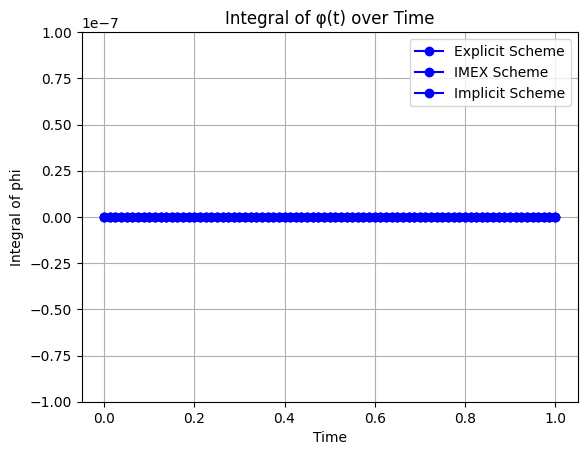

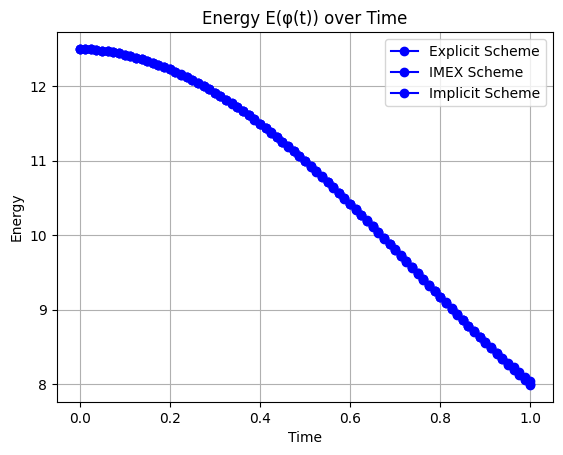

In [86]:

#Here is only from the last values of maxh and tau
time = [i * Tau[-1] for i in range(len(energy)+1)]

# Plot the integral data
plt.plot(time, Explicit_integral, marker='o', color='b', label='Explicit Scheme')
plt.plot(time, IMEX_integral, marker='o', color='b', label='IMEX Scheme')
plt.plot(time, Implicit_integral, marker='o', color='b', label='Implicit Scheme')
plt.ylim(-1e-7, 1e-7)
plt.xlabel("Time")
plt.ylabel("Integral of phi")
plt.title("Integral of φ(t) over Time")
plt.legend()
plt.grid()
plt.show()


# Plot the energy data
plt.plot(time, Explicit_energy, marker='o', color='b', label='Explicit Scheme')
plt.plot(time, IMEX_energy, marker='o', color='b', label='IMEX Scheme')
plt.plot(time, Implicit_energy, marker='o', color='b', label='Implicit Scheme')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy E(φ(t)) over Time")
plt.legend()
plt.grid()
plt.show()

In [87]:
def time_adaptivity(tau,steps,min_frac):

    min_step = tau*min_frac
    time_steps = np.logspace(np.log10(min_step), np.log10(tau), steps)
    
    return time_steps


In [88]:
N = np.array([1,2,3,4])
H = 0.2*2.0**(-N)
Tau =  H 
import math
max_tau = H[1]

time_step = time_adaptivity(T,math.ceil(T / max_tau),1e-5)
print(time_step)

[1.00000000e-05 1.83298071e-05 3.35981829e-05 6.15848211e-05
 1.12883789e-04 2.06913808e-04 3.79269019e-04 6.95192796e-04
 1.27427499e-03 2.33572147e-03 4.28133240e-03 7.84759970e-03
 1.43844989e-02 2.63665090e-02 4.83293024e-02 8.85866790e-02
 1.62377674e-01 2.97635144e-01 5.45559478e-01 1.00000000e+00]


In [89]:
def time_adaptive_FullyExplicitScheme(mesh,fes,phi,mu,v,w,phi_old,epsilon,gamma,M,max_tau,T):
    
    gfu = GridFunction(fes)
    gfut = GridFunction(gfu.space, multidim = 0)
    gfut.AddMultiDimComponent(gfu.vec)

    L2_error = []
    integral = []
    energy = []

    time_steps = time_adaptivity(T,math.ceil(T / max_tau),1e-5)


    time_steps[0] = 0

    for i in range(len(time_steps)):
        t = time_steps[i]

        #Defining Bilinear form
        A = BilinearForm(fes)
        A += phi*v*dx+tau*M*grad(mu)*grad(v)*dx + mu*w*dx-epsilon*grad(phi)*grad(w)*dx
        A.Assemble()
        
        rhs1 = phi_dt(t)-M*mu_lap() 
        rhs2 = mu_exact() - gamma*(phi_exact(t)**3 - phi_exact(t)) + epsilon*phi_lap(t)
            
        #Defining linear form
        f=LinearForm(fes)
        f+= tau*rhs1*v*dx+ phi_old*v*dx+gamma*(phi_old**3-phi_old)*w*dx + rhs2*w*dx
        f.Assemble()

        #Solving for phi
        gfu.vec.data = A.mat.Inverse(freedofs = fes.FreeDofs())*f.vec

        e_h = gfu.components[0]-phi_exact(t)
        norm = np.sqrt(Integrate(e_h*e_h,mesh))
        L2_error.append(norm)
        int_phi = Integrate(gfu.components[0],mesh)
        E = Integrate(epsilon/2*(grad(gfu.components[0])**2)+gamma/4*(gfu.components[0]**2-1)**2,mesh)
        L2_error.append(norm)
        integral.append(int_phi)
        energy.append(E)

        #Storing and updating phi
        gfut.AddMultiDimComponent(gfu.vec)
        phi_old.vec.data = gfu.components[0].vec


    return gfut,gfu, L2_error, integral,energy

In [90]:
df, integral, energy = convergence_analysis(H,Tau,time_adaptive_FullyExplicitScheme)

In [91]:
df

,tau,maxh,L2_error
0,0.1000,0.1000,0.437613
1,0.0500,0.1000,0.374657
2,0.0250,0.1000,0.247336
3,0.0125,0.1000,0.360363
4,0.1000,0.0500,0.437607
5,0.0500,0.0500,0.374650
6,0.0250,0.0500,0.247339
7,0.0125,0.0500,0.360294
8,0.1000,0.0250,0.437606
9,0.0500,0.0250,0.374650


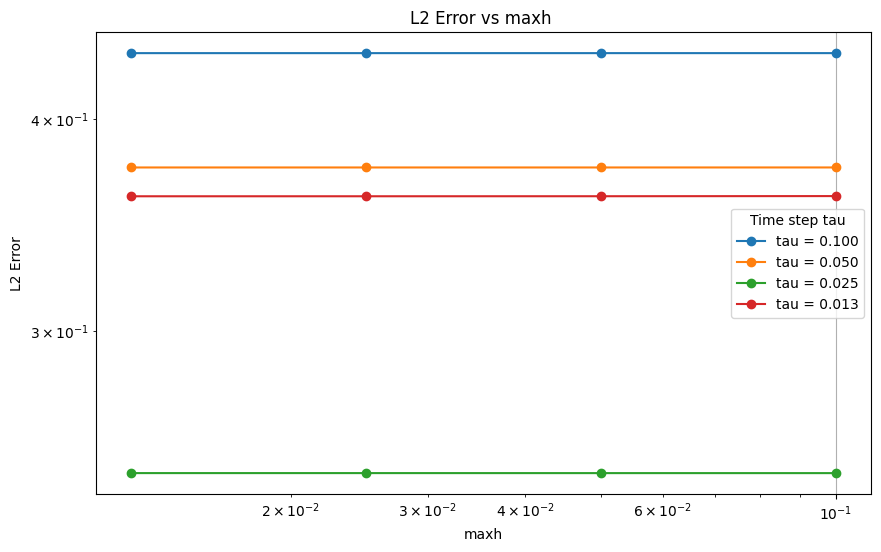

In [92]:
plt.figure(figsize=(10, 6))
for tau in df['tau'].unique():
    df_tau = df[df['tau'] == tau]
    plt.loglog(df_tau['maxh'], df_tau['L2_error'], marker='o', label=f'tau = {tau:.3f}')
plt.xlabel('maxh')
plt.ylabel('L2 Error')
plt.title('L2 Error vs maxh ')
plt.legend(title="Time step tau")
plt.grid(True)
plt.show()